In [31]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [32]:
# get input data
deepmimo = False

function_folder = "sin_gaussian_-23.42"

data = CreateInput(function_folder, deepmimo)

tensors = data.get_tensors()

In [33]:
tensors['train'][1].shape

torch.Size([700])

# Evaluate KAN

In [ ]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1024]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0],
        'kan__deepmimo': [True]
    }

else:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1,1,1], [1,2,1], [1, 3, 1], [1,5,1] , [1,7,1]],   #[1, 3, 3, 1], [1, 3, 3, 3, 1], [1, 5, 1], [1, 5, 5, 1], [1, 5, 5, 5, 1], [1, 7, 1], [1, 7, 7, 1], [1, 7, 7, 7, 1]
        'kan__grid': [3,2,1],
        'kan__k': [5,2,1],
        'kan__seed': [42],
        'kan__lr': [0.001, 0.0001],
        'kan__lamb': [0],
        'kan__deepmimo': [False],
        'kan__epochs': [100]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)"""
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)
# Fit RandomizedSearchCV
grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['kan__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_KAN = grid_search.best_params_


| train_loss: 6.86e-01 | test_loss: 6.75e+00 | reg: 3.58e+00 | : 100%|█| 20/20 [00:01<00:00, 15.37it
| train_loss: 6.86e-01 | test_loss: 2.47e+01 | reg: 3.74e+00 | : 100%|█| 20/20 [00:01<00:00, 11.46it
| train_loss: 6.87e-01 | test_loss: 2.05e+01 | reg: 4.01e+00 | : 100%|█| 20/20 [00:01<00:00, 11.09it
| train_loss: 6.96e-01 | test_loss: 7.93e+00 | reg: 3.86e+00 | : 100%|█| 20/20 [00:01<00:00, 10.87it
| train_loss: 6.96e-01 | test_loss: 1.57e+01 | reg: 5.40e+00 | : 100%|█| 20/20 [00:01<00:00, 10.32it
| train_loss: 6.89e-01 | test_loss: 9.90e+00 | reg: 4.16e+00 | : 100%|█| 20/20 [00:02<00:00,  9.88it
| train_loss: 6.90e-01 | test_loss: 6.55e+01 | reg: 8.46e+00 | : 100%|█| 20/20 [00:02<00:00,  9.15it
| train_loss: 6.88e-01 | test_loss: 9.45e+00 | reg: 7.35e+00 | : 100%|█| 20/20 [00:02<00:00,  8.99it
| train_loss: 6.86e-01 | test_loss: 1.86e+02 | reg: 7.15e+00 | : 100%|█| 20/20 [00:02<00:00,  8.79it
| train_loss: 6.83e-01 | test_loss: 1.43e+01 | reg: 7.69e+00 | : 100%|█| 20/20 [00:02<00:00

Best Parameters: {'kan__data': [], 'kan__deepmimo': False, 'kan__epochs': 20, 'kan__grid': 1, 'kan__k': 1, 'kan__lamb': 0, 'kan__lr': 0.0001, 'kan__seed': 42, 'kan__width': [[1, 0], [1, 0], [1, 0]]}
Best Cross-Validation Score: -0.4839193642139435


In [35]:
# evaluate KAN with optimal params
kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'], deepmimo=deepmimo, epochs=100, results_path=f"./results/KAN/{function_folder}")
kan_model.load_data(tensors)
loss_data, time_elapsed = kan_model.fit()
y_preds = kan_model.predict()

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.93e-01 | test_loss: 7.03e-01 | reg: 2.64e+00 | : 100%|█| 100/100 [00:01<00:00, 90.68

saving model version 0.1


In [36]:
if deepmimo:
    kan_model = KANModel(width=[1024, 10,10, 1024], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()

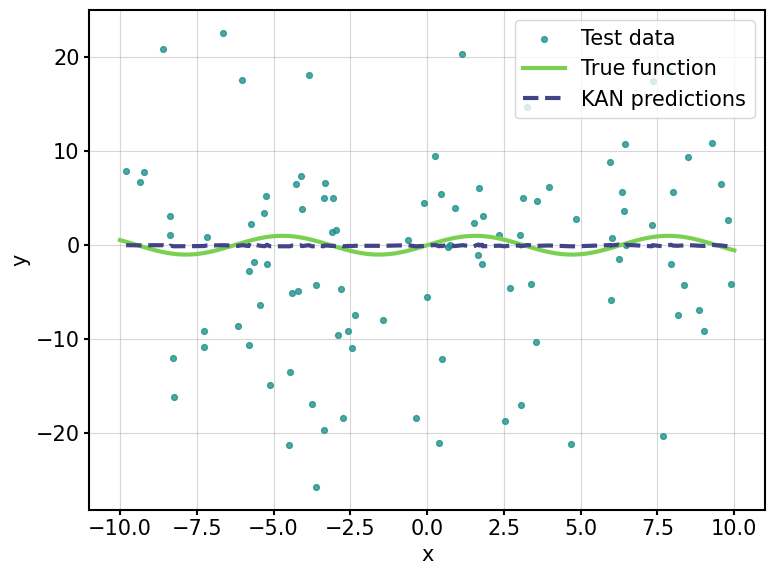

In [37]:
# plot pred and true
if deepmimo:
    kan_model.plot_deepmimo(data=tensors, y_preds=y_preds['preds'], type_='test', save=True)
else:
    kan_model.plot_prediction(data=tensors, y_preds=y_preds['preds'], type_='test', save=True)

In [38]:
# plot noise and true
if deepmimo:
    kan_model.plot_deepmimo(data=tensors, y_preds=tensors['test'][0][:2,:], type_='test', save=True)

In [39]:
# diffrence in noise and true
#torch.sum(np.abs(tensors['test'][0][:1,:] - tensors['test'][1][:1,:]))

In [40]:
# diffrence pred and true
#torch.sum(np.abs(y_preds['preds'][0] - tensors['test'][1][:1,:]))

saved loss to  ./results/KAN/sin_gaussian_-23.42/loss.png
Model parameters saved to ./results/KAN/sin_gaussian_-23.42/model_params.txt


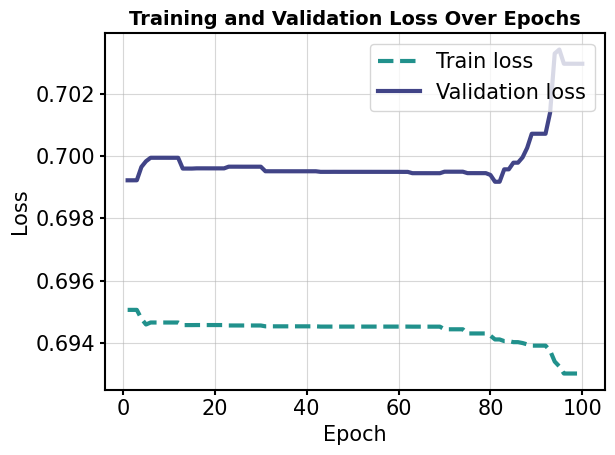

In [41]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=True)

# Evaluate MLP

In [42]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1024],
        'mlp__hidden_size': [[64,64],[500,500],[2000],[1000,1000],[300,300,300],[5000],[3000,3000],[32,32],[128,128],[256,64]],
        'mlp__output_size': [1024],
        'mlp__epochs': [100],
        'mlp__deepmimo': [True]
    }

else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1],
        'mlp__hidden_size': [[1], [2], [3], [3, 3], [3, 3, 3], [5], [5, 5], [5, 5, 5], [7], [7, 7], [7, 7, 7]],
        'mlp__output_size': [1],
        'mlp__epochs': [20],
        'mlp__deepmimo': [False],
        'mlp__lr': [0.001, 0.0001]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

/Users/zeshenbao/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/20 [00:00<?, ?it/s]/Users/zeshenbao/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/20 [00:00<?, ?it/s]/Users/zeshenbao/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/20 [00:00<?, ?

Best Parameters: {'mlp__output_size': 1, 'mlp__lr': 0.0001, 'mlp__input_size': 1, 'mlp__hidden_size': [5, 5, 5], 'mlp__epochs': 20, 'mlp__deepmimo': False, 'mlp__data': []}
Best Cross-Validation Score: -0.48971968293190005


In [43]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'],result_path=f"./results/MLP/{function_folder}")
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=100, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)

100%|██████████| 100/100 [00:01<00:00, 67.92it/s]


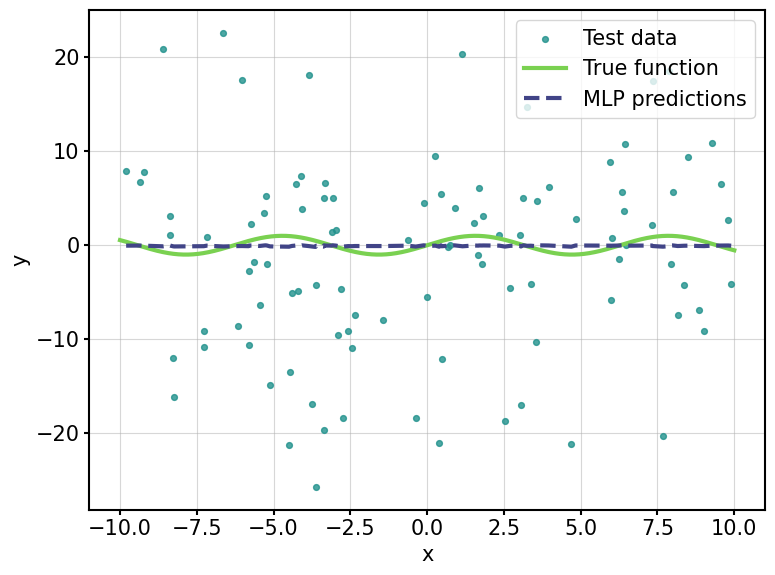

In [ ]:
# plot predictions
if deepmimo:
    pred_sample = y_preds['preds'][0]
    true_sample = tensors['test'][1][0]
    mlp_model.plot_deepmimo(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=True)
else:
    mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=True)

saved loss to  ./results/MLP/sin_gaussian_-23.42/loss.png
Model parameters saved to ./results/MLP/sin_gaussian_-23.42/model_params.txt


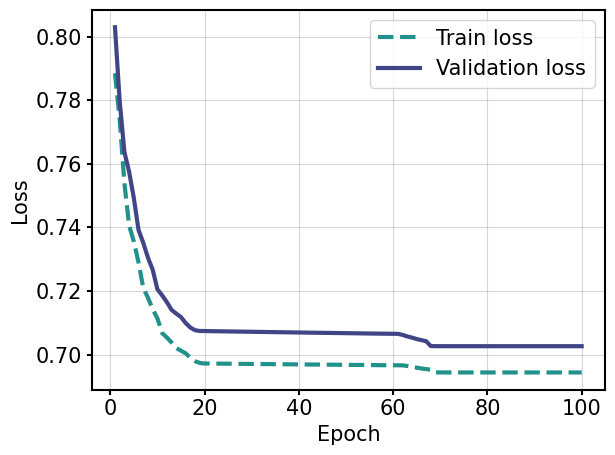

In [45]:
# plot loss

mlp_model.plot_loss(loss_data=loss_data_MLP, save=True, deepmimo=deepmimo)